# Analysis 2-3: Interpretation of bootstrapped logistic regressions. Python 3 Kernel (Not Spylon)

In [2]:
# %load src/python/e2_imports.py
import sklearn.preprocessing
import numpy as np
import pandas as pd
from pyspark.sql.functions import collect_list, struct, col, explode
from sklearn.preprocessing import LabelBinarizer

from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

import mlflow
from src.python.e2_drug_lookup import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from src.python.helpers import plotfig_magic

In [3]:
import plotly.graph_objs as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.io import write_image
import plotly.graph_objs as go
import plotly.figure_factory as plotly_ff

init_notebook_mode(connected=True)

from src.python.csv_to_dict import csv_to_dict
drugdict = csv_to_dict("datasets/atc_to_descr/2014_atc.csv")
#print(drugdict.keys())

In [4]:
metrics_basedir = "spark-warehouse/numpy/e2/runs/FINAL/"
#metrics_basedir = "spark-warehouse/numpy/e2/runs/run1/"
n_bootstrap_samples = 2000

In [5]:
a = np.load(metrics_basedir+"0.npy")
enc_load = np.load(metrics_basedir+"encoder.npy")

a.item().get("train_accuracy")
drugencoder = enc_load.item()
print(a.item().keys())

dict_keys(['train_accuracy', 'train_confusion', 'test_accuracy', 'test_confusion', 'model_coefficients', 'model_intercept', 'data_train_shape', 'data_test_shape', 'concordance'])


In [6]:
print(a.all().keys())
a.item().get("test_confusion")

dict_keys(['train_accuracy', 'train_confusion', 'test_accuracy', 'test_confusion', 'model_coefficients', 'model_intercept', 'data_train_shape', 'data_test_shape', 'concordance'])


array([[57502,  6685],
       [23123, 15980]])

In [7]:
confusion = a.item().get("test_confusion")
confusion_fracs = confusion/confusion.sum()

########
trace = go.Heatmap(
    z=confusion_fracs,
    x=["Unhospitalized", "Hospitalized"],
    y=["Unhospitalized", "Hospitalized"]
                  
                  )
layout = go.Layout(
    title="Confusion matrix, normalized by scale",
    xaxis=go.layout.XAxis(
        title="Predicted label"
    ),
    yaxis=go.layout.YAxis(
        title="True label"
    )
)
data = [trace]
fig = go.Figure(data=data, layout=layout)
#iplot(fig)

In [8]:
confusion = a.item().get("test_confusion")
confusion_frac_by_class = confusion/confusion.sum(axis=0)


#####
trace = go.Heatmap(reversescale=False, colorscale="Viridis",
    z=confusion_frac_by_class,
    x=["Unhospitalized", "Hospitalized"],
    y=["Unhospitalized", "Hospitalized"]
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
#iplot(fig)
#print(fig)

# Plot the confusion matrix, normalized so that the sum of each predicted label is 1
* This means that we can display the accuracy of each predicted label

In [9]:
confusion_with_sums = np.zeros(shape=(3,3))
confusion_with_sums[1:3,1:3] = confusion
confusion_with_sums[0,1:3] = np.sum(confusion, axis=0)
confusion_with_sums[1:3,0] = np.sum(confusion, axis=1)
confusion_with_sums[0,0]=np.sum(confusion)
print(confusion_with_sums)
print(confusion)
#"""
fig = plotly_ff.create_annotated_heatmap(
        confusion_with_sums,
        colorscale="Hot",
        
        x=["Sum", "Unhospitalized", "Hospitalized,"],
        y=["Sum", "Unhospitalized", "Hospitalized"],
    )

fig.layout.title = "Confusion Matrix"
fig.layout.xaxis = xaxis=go.layout.XAxis(
        title="Predicted label",
        autorange='reversed',
        side='top'
    )
fig.layout.yaxis = yaxis=go.layout.YAxis(
        title="Actual label",
    )
fig["layout"].update(width=800, height=800)
fig.layout.margin=go.layout.Margin(
        l=120,
        r=50,
        b=100,
        t=150,
        pad=4
    )
#"""
import plotly.io as pio
#fig.data[0].showscale=True
iplot(fig)
#print(fig)


[[103290.  80625.  22665.]
 [ 64187.  57502.   6685.]
 [ 39103.  23123.  15980.]]
[[57502  6685]
 [23123 15980]]


In [10]:
conf_norm_with_sums = np.zeros(shape=(3,3))
conf_normed = confusion.copy()/confusion.sum()
conf_norm_with_sums[1:3,1:3] = conf_normed
conf_norm_with_sums[0,1:3] = np.sum(conf_normed, axis=0)
conf_norm_with_sums[1:3,0] = np.sum(conf_normed, axis=1)
conf_norm_with_sums[0,0]=np.sum(conf_normed)
print(conf_norm_with_sums)
print(confusion)
#"""
fig = plotly_ff.create_annotated_heatmap(
        conf_norm_with_sums,
        colorscale="Hot",
        
        x=["Sum", "Unhospitalized", "Hospitalized,"],
        y=["Sum", "Unhospitalized", "Hospitalized"],
    )

fig.layout.title = "Confusion Matrix, fractional"
fig.layout.xaxis = xaxis=go.layout.XAxis(
        title="Predicted label",
        autorange='reversed',
        side='top'
    )
fig.layout.yaxis = yaxis=go.layout.YAxis(
        title="Actual label",
    )
fig["layout"].update(width=800, height=800)
fig.layout.margin=go.layout.Margin(
        l=120,
        r=50,
        b=100,
        t=150,
        pad=4
    )
#"""
import plotly.io as pio
#fig.data[0].showscale=True
iplot(fig)
#print(fig)


[[1.         0.78056927 0.21943073]
 [0.62142511 0.55670442 0.06472069]
 [0.37857489 0.22386485 0.15471004]]
[[57502  6685]
 [23123 15980]]


In [11]:
fig = plotly_ff.create_annotated_heatmap(
        confusion_frac_by_class,
        colorscale="Viridis",
        x=["Unhospitalized", "Hospitalized"],
        y=["Unhospitalized", "Hospitalized"],
    )

fig.layout.title = "Confusion Matrix Normalized by Predicted Label"
fig.layout.xaxis = xaxis=go.layout.XAxis(
        title="Predicted label",
        autorange='reversed',
        side='top'
    )
fig.layout.yaxis = yaxis=go.layout.YAxis(
        title="Actual label",
    )
fig.layout.margin=go.layout.Margin(
        l=120,
        r=50,
        b=100,
        t=150,
        pad=4
    )




fig.data[0].showscale=True
iplot(fig)
#print(fig)

In [12]:
drugencoder.classes_.shape

(949,)

In [13]:

drugs_ordered = drugencoder.classes_

def try_lookup(drugdict, name):
    try:
        description = drugdict[name]
        return name+":"+description
    except:
        return name+":"+"No description"
name_embeddings = list(map(lambda x: try_lookup(drugdict, x), drugs_ordered))
print(name_embeddings[:10])
drugs_ordered.shape


['A01AA01:sodium fluoride', 'A01AB03:chlorhexidine', 'A01AB04:amphotericin B', 'A01AB09:miconazole', 'A01AC01:triamcinolone', 'A01AD01:epinephrine', 'A01AD02:benzydamine', 'A02AA04:magnesium hydroxide', 'A02AC01:calcium carbonate', 'A02AD01:ordinary salt combinations']


(949,)

In [14]:
def load_model_params(npy_file):
    a = npy_file.item().get("model_coefficients")
    b = npy_file.item().get("model_intercept")
    return a, b

def load_bootstrap_model_params(experiment_path, n_samples):
    work_size = range(0, n_samples)
    coef_mat = None
    intercept_mat = None
    for i in work_size:
        npy_file = np.load(metrics_basedir+str(i)+".npy")
        coef, intercept = load_model_params(npy_file)
        if coef_mat is None:
            coef_mat = coef
        else:
            coef_mat = np.concatenate((coef_mat, coef), axis=0)
        if intercept_mat is None:
            intercept_mat=intercept
        else:
            intercept_mat = np.vstack((intercept_mat, intercept))
    return (coef_mat, intercept_mat)

In [15]:
experiment_path =  metrics_basedir

model_param_dict = {}


p_n = [experiment_path, n_bootstrap_samples]

coefs, intercepts = load_bootstrap_model_params(p_n[0], p_n[1])
model_param_dict["coefs"] = coefs
model_param_dict["intercepts"] = intercepts




print(model_param_dict.keys())

dict_keys(['coefs', 'intercepts'])


# We define relevancy as mean/stdev
* Weights that deviate from zero consistently get a high score
* High-variance parameters have their relevancy closer to zero

In [16]:
intercepts_ = model_param_dict["intercepts"]
coefs_ = model_param_dict["coefs"]

coef_means = coefs_.mean(axis=0)
coef_stds = coefs_.std(axis=0)

# Remove where standard deviations are 0
no_zeros = np.where(coef_stds!=0.0)
coef_means = coef_means[no_zeros]
coef_stds = coef_stds[no_zeros]
drugs_ordered_no_zero_weights = drugs_ordered[no_zeros]
coef_relevancy = coef_means/coef_stds

ordering = np.argsort(-coef_relevancy)
#print(coef_stds)

# Simple visualizations of mean and standard deviations after sorting by relevance

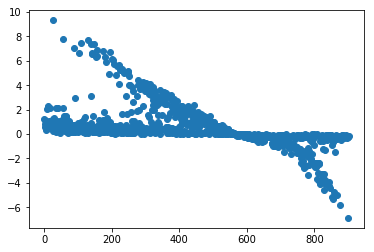

In [17]:
plt.scatter(np.arange(0,ordering.shape[0]),coef_means[ordering])

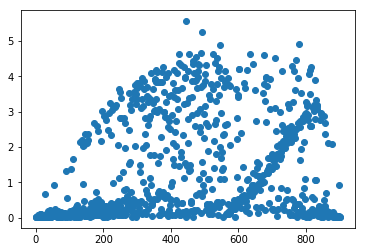

In [18]:
plt.scatter(np.arange(0,ordering.shape[0]), coef_stds[ordering])

# We create interactive plots with Plotly from these data

## Colorize the boxplot by first level ATC classification

In [19]:
import string
import random
def filter_letter(x):
    try:
        drugdict[x]
        return True
    except:
        return False

letters = filter(
    filter_letter, 
    map(
        lambda x: x, string.ascii_uppercase
    )
)

random_color = \
    lambda: "rgb"+str((random.randint(0,255), random.randint(0,255), random.randint(0,255)))
#Create hierarchical colormap for L1 of ATC codes
colormap = {}
for l in letters:
    colormap[l] = random_color()

In [20]:

def create_boxplot(means, stdevs, drugs_array):
    data = []
    #print(ordering_.shape)
    #iterate over each drug, and also model coefficient
    for i in range(0,drugs_array.shape[0]):
        #create a box for the boxplot for each drug
        drug_code = drugs_array[i]
        box = go.Scatter(
            x = [i],
            y = [means[i]],
            error_y = dict(
                type="data",
                array=[stdevs[i]],
                visible=True
            )
            , name = drug_code
            , text = try_lookup(drugdict, drug_code)
            #, textposition='auto'
            #, hoverinfo = 'text'
            , marker = dict(
                color=colormap[drug_code[0]]
                )
            )
        data.append(box) 
    layout = go.Layout(  
        showlegend=False
        , paper_bgcolor='rgb(243, 243, 243)'
        , plot_bgcolor='rgb(243, 243, 243)',
    )
    fig = go.Figure(
        data=data
        ,layout=layout
    )
    
    return fig

# All parameters with error bars sorted by relevance

In [21]:
# Apply Ordering to means, standard deviations and drug set so they correspond with each other
ord_coef_means, ord_coef_std, ord_drugs = map(
    (lambda x: x[ordering]),
    [coef_means, coef_stds, drugs_ordered_no_zero_weights]
)
fig = create_boxplot(ord_coef_means, ord_coef_std, ord_drugs)
fig.layout.update(
    title="Logistic Regression Params from 2000 bootstraps, 1 stdev error.",
    xaxis={"title":"Drug"},
    yaxis={"title":"Log odds ratio of hospitalization"}
)

iplot(fig, filename="plots/bootstrap_all_drugs_with_relevance.html")

# 95% conficence intervals, drugs with stdev > 0.1 omitted and 95% confidence does not cross equilibrium (0 log odds ratio)

In [22]:
# Obtain subset where standard deviation is less than 0.1
# And where the 95% confidence interval does not cross the 0-line
where_95_confidence_does_not_cross_0 = (np.abs(ord_coef_means)-1.96*ord_coef_std) > 0.0 
selection = ((ord_coef_std < 0.1) & where_95_confidence_does_not_cross_0)
#print(selection)
coef_means2 = np.copy(ord_coef_means)[selection]

coef_stds2 = np.copy(ord_coef_std)[selection] 
coef_95_p_c = 1.96*coef_stds2

ord_drugs2 = ord_drugs[selection]
print(ord_drugs2.shape)
fig = create_boxplot(coef_means2, coef_95_p_c, ord_drugs2)
fig.layout.update(
    title="Bootstrapped Logistic Regression Parameters, 95% confidence, omitted high-variance parameters",
    xaxis={"title":"Drug"},
    yaxis={"title":"Log odds ratio of hospitalization, Odds(Hospitalization|Drug)"}
)
iplot(fig, filename="plots/bootstrap_all_drugs_with_relevance.html")

(137,)


# 98% conficence intervals, omitted drugs where 98% confidence interval crosses equilibrium (0 log odds ratio)

In [23]:
# Obtain subset where standard deviation is less than 0.1
# And where the 95% confidence interval does not cross the 0-line

where_98_confidence_does_not_cross_0 = (np.abs(ord_coef_means)-2.58*ord_coef_std) > 0.0 
selection = (where_98_confidence_does_not_cross_0)
#print(selection)
coef_means2 = np.copy(ord_coef_means)[selection]

coef_stds2 = np.copy(ord_coef_std)[selection] 
coef_95_p_c = 2.58*coef_stds2
ord_drugs2 = ord_drugs[selection]

print(ord_drugs2.shape)
fig = create_boxplot(coef_means2, coef_95_p_c, ord_drugs2)
fig.layout.update(
    title="Logistic Regression params, by signal to noise ratio, 98% confidence",
    xaxis={"title":"Drug"},
    yaxis={"title":"Log odds ratio of hospitalization"}
)
iplot(fig, filename="plots/bootstrap_all_drugs_with_relevance.html")

(203,)


# Following is a printount of the drugs retrieved after filtering drugs with high standard deviation

In [24]:
table_representation = pd.DataFrame(np.array([list(map(lambda x: try_lookup(drugdict, x), ord_drugs2)), 
                            ord_drugs2, coef_means2, coef_stds2, ]).T, 
                  columns = ["Name","Drug Code","Mean log odds","Stdev"]
            )

In [25]:
table_representation[:60]

,Name,Drug Code,Mean log odds,Stdev
0,C03CA02:bumetanide,C03CA02,1.20295,0.0296903
1,B01AC04:clopidogrel,B01AC04,1.14456,0.0302084
2,B01AA03:warfarin,B01AA03,0.591815,0.0156853
3,C03CA01:furosemide,C03CA01,0.799248,0.0215458
4,B01AC06:acetylsalicylic acid,B01AC06,0.299542,0.0098946
5,N02BE01:paracetamol,N02BE01,0.714976,0.0240768
6,H02AB06:prednisolone,H02AB06,0.669289,0.0238791
7,N05CF01:zopiclone,N05CF01,0.421781,0.0165087
8,B01AC24:ticagrelor,B01AC24,2.02432,0.0834419
9,A02BC02:pantoprazole,A02BC02,0.462486,0.0194953


In [26]:
table_representation[60:120]

,Name,Drug Code,Mean log odds,Stdev
60,B03XA02:darbepoetin alfa,B03XA02,1.46943,0.186537
61,N03AG01:valproic acid,N03AG01,0.682804,0.0876006
62,C07AB07:bisoprolol,C07AB07,0.260785,0.0344387
63,H02AB10:cortisone,H02AB10,0.945117,0.125151
64,L02BX02:degarelix,L02BX02,1.4956,0.20295
65,A06AB08:sodium picosulfate,A06AB08,1.03592,0.146223
66,B03AA01:ferrous glycine sulfate,B03AA01,1.39064,0.196317
67,R03AC02:salbutamol,R03AC02,0.231673,0.0327536
68,R03AK06:salmeterol and fluticasone,R03AK06,0.18302,0.0266999
69,A12BA01:potassium chloride,A12BA01,0.427463,0.0638504


In [27]:
table_representation[120:180]

,Name,Drug Code,Mean log odds,Stdev
120,"S01ED51:timolol, combinations",S01ED51,0.117552,0.0291098
121,J01AA02:doxycycline,J01AA02,0.268356,0.066753
122,A12CA01:sodium chloride,A12CA01,1.3966,0.352323
123,N03AF02:oxcarbazepine,N03AF02,0.687978,0.177342
124,N05BA01:diazepam,N05BA01,0.13755,0.0360279
125,R03DA04:theophylline,R03DA04,0.366287,0.0997039
126,M05BX04:denosumab,M05BX04,0.781297,0.213269
127,N06AB04:citalopram,N06AB04,0.193703,0.0528784
128,C04AD03:pentoxifylline,C04AD03,0.656409,0.179311
129,M01AE02:naproxen,M01AE02,0.181789,0.0497399


In [28]:
table_representation[180:]

,Name,Drug Code,Mean log odds,Stdev
180,A10BD07:metformin and sitagliptin,A10BD07,-0.213672,0.0661645
181,R01BA01:phenylpropanolamine,R01BA01,-0.51278,0.158549
182,R01AD09:mometasone,R01AD09,-0.111803,0.0341225
183,D01BA02:terbinafine,D01BA02,-0.272303,0.0824382
184,C03EA01:hydrochlorothiazide and potassium-spar...,C03EA01,-0.12003,0.036291
185,L04AX03:methotrexate,L04AX03,-0.211496,0.0579138
186,C09BA02:enalapril and diuretics,C09BA02,-0.124468,0.0340251
187,R06AE07:cetirizine,R06AE07,-0.0919456,0.024753
188,C07BB07:bisoprolol and thiazides,C07BB07,-0.344997,0.0813392
189,C09CA04:irbesartan,C09CA04,-0.155392,0.0364174


In [29]:
table_representation.to_csv("plots/druglist.csv")